In [ ]:
# install modules
!pip install biopython
!pip install torch
!pip install transformers
!pip install tape_proteins
!pip install transformers
!pip install sentencepiece
!pip install tensorflow pandas scikit-learn matplotlib seaborn

# !pip install sklearn


     ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
     ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
     ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
     ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
     ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
     ---------------------------------------- 0.0/2.7 MB 187.9 kB/s eta 0:00:15
     ---------------------------------------- 0.0/2.7 MB 187.9 kB/s eta 0:00:15
      --------------------------------------- 0.0/2.7 MB 140.3 kB/s eta 0:00:20
      --------------------------------------- 0.0/2.7 MB 140.3 kB/s eta 0:00:20
      --------------------------------------- 0.0/2.7 MB 140.3 kB/s eta 0:00:20
      --------------------------------------- 0.0/2.7 MB 140.3 kB/s eta 0:00:20
      --------------------------------------- 0.1/2.7 MB 117.2 kB/s eta 0:00:23
      --------------------------------------- 0.1/2.7 MB 117.2 kB/s eta 0:00:23
     

In [ ]:
import os
import pandas as pd
import numpy as np
from Bio import SeqIO
from Bio.Seq import translate
from Bio.SeqUtils.ProtParam import ProteinAnalysis
import re
from Bio.Seq import Seq # Biopython for sequence objects
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import AutoModel, AutoTokenizer
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf


In [ ]:
# Define the path to the folder containing genomic sequences
path = 'Genomic Sequences'

In [ ]:
# Create a list to store data from the sequence files
data = []
for subdir in os.listdir(path):
    if os.path.isdir(os.path.join(path, subdir)):
        for file in os.listdir(os.path.join(path, subdir)):
            if file.lower().endswith(('.fna', '.fasta', '.txt', '.csv')):
                for record in SeqIO.parse(os.path.join(path, subdir, file), 'fasta'):
                    genomic_sequence = str(record.seq)
                    # Remove all "N" characters from the genomic sequence
                    genomic_sequence = genomic_sequence.replace('N', '')
                    data.append([file.split('.')[0], subdir, genomic_sequence])
# Create a DataFrame to store the data
df = pd.DataFrame(data, columns=['ID', 'Genome_type', 'Genomic_Sequence'])

In [ ]:
df

,ID,Genome_type,Genomic_Sequence
0,NC_004161,Ebola,CGGACACACAAAAAGAAAAAAGGTTTTTTAAGACTTTTTGTGTGCG...
1,NC_006432,Ebola,CGGACACACAAAAAGAAAGAAAAGTTTTTTATACTTTTTGTGTGCG...
2,NC_014373,Ebola,CGGACACACAAAAAGAATGAAGGATTTTGAATCTTTATTGTGTGCG...
3,NC_039345,Ebola,CGGACACACAAAAAGAAAGAAGAATTTTTTAACTTTTTTGTGTGAG...
4,NC_026433,Influenza_A,ATGAAGGCAATACTAGTAGTTCTGCTATATACATTTGCAACCGCAA...
5,NC_026434,Influenza_A,ATGAATCCAAACCAAAAGATAATAACCATTGGTTCGGTCTGTATGA...
6,NC_026435,Influenza_A,ATGGATGTCAATCCGACTCTACTTTTCCTAAAAATTCCAGCGCAAA...
7,NC_026436,Influenza_A,ATGGCGTCTCAAGGCACCAAACGATCATATGAACAAATGGAGACTG...
8,NC_026437,Influenza_A,ATGGAAGACTTTGTGCGACAATGCTTCAATCCAATGATCGTCGAGC...
9,NC_026438,Influenza_A,ATGGAGAGAATAAAAGAACTGAGAGATCTAATGTCGCAGTCCCGCA...


In [ ]:
df["RNA"] = df["Genomic_Sequence"].apply(lambda x: str(Seq(x).transcribe()))

In [ ]:
# Function to trim sequences to a multiple of three
def trim_to_multiple_of_three(sequence):
    remainder = len(sequence) % 3
    if remainder != 0:
        # Calculate the number of nucleotides to remove to reach a multiple of three
        num_nucleotides_to_remove = remainder
        # Trim the sequence by removing nucleotides from the end
        sequence = sequence[:-num_nucleotides_to_remove]
    return sequence

# Apply the function to trim sequences
df["RNA"] = df["RNA"].apply(trim_to_multiple_of_three)

In [ ]:
# Protein sequencing using BioPython
df["Protein"] = df["RNA"].apply(lambda x: str(Seq(x).translate()))

In [ ]:
# Define function to count amino acids
def count_protein(seq):
    analysed_seq = ProteinAnalysis(seq) # create ProteinAnalysis object
    return sum(analysed_seq.count_amino_acids().values()) # sum up the values of the amino acid dictionary

# Apply function to protein column
df["protein_count"] = df["Protein"].apply(count_protein) # store in new column

In [ ]:
# print dataframe
df

,ID,Genome_type,Genomic_Sequence,RNA,Protein,protein_count
0,NC_004161,Ebola,CGGACACACAAAAAGAAAAAAGGTTTTTTAAGACTTTTTGTGTGCG...,CGGACACACAAAAAGAAAAAAGGUUUUUUAAGACUUUUUGUGUGCG...,RTHKKKKGFLRLFVCE*L*GRLTVFLSLRYTLKLRLRFSSLLFCNF...,5864
1,NC_006432,Ebola,CGGACACACAAAAAGAAAGAAAAGTTTTTTATACTTTTTGTGTGCG...,CGGACACACAAAAAGAAAGAAAAGUUUUUUAUACUUUUUGUGUGCG...,RTHKKKEKFFILFVCE*L*GRLIIFLKLKLILTLRLISSFTNWRQF...,5870
2,NC_014373,Ebola,CGGACACACAAAAAGAATGAAGGATTTTGAATCTTTATTGTGTGCG...,CGGACACACAAAAAGAAUGAAGGAUUUUGAAUCUUUAUUGUGUGCG...,RTHKKNEGF*IFIVCE*LRGRLKIFLSLKLKLRF*SRRIDPQYQH*...,5849
3,NC_039345,Ebola,CGGACACACAAAAAGAAAGAAGAATTTTTTAACTTTTTTGTGTGAG...,CGGACACACAAAAAGAAAGAAGAAUUUUUUAACUUUUUUGUGUGAG...,RTHKKKEEFFNFFV*E*L*GRLRTLLSWLNSLDLTFKLRS*FSYNL...,5984
4,NC_026433,Influenza_A,ATGAAGGCAATACTAGTAGTTCTGCTATATACATTTGCAACCGCAA...,AUGAAGGCAAUACUAGUAGUUCUGCUAUAUACAUUUGCAACCGCAA...,MKAILVVLLYTFATANADTLCIGYHANNSTDTVDTVLEKNVTVTHS...,564
5,NC_026434,Influenza_A,ATGAATCCAAACCAAAAGATAATAACCATTGGTTCGGTCTGTATGA...,AUGAAUCCAAACCAAAAGAUAAUAACCAUUGGUUCGGUCUGUAUGA...,MNPNQKIITIGSVCMTIGMANLILQIGNIISIWISHSIQLGNQNQI...,469
6,NC_026435,Influenza_A,ATGGATGTCAATCCGACTCTACTTTTCCTAAAAATTCCAGCGCAAA...,AUGGAUGUCAAUCCGACUCUACUUUUCCUAAAAAUUCCAGCGCAAA...,MDVNPTLLFLKIPAQNAISTTFPYTGDPPYSHGTGTGYTMDTVNRT...,757
7,NC_026436,Influenza_A,ATGGCGTCTCAAGGCACCAAACGATCATATGAACAAATGGAGACTG...,AUGGCGUCUCAAGGCACCAAACGAUCAUAUGAACAAAUGGAGACUG...,MASQGTKRSYEQMETGGERQDATEIRASVGRMIGGIGRFYIQMCTE...,497
8,NC_026437,Influenza_A,ATGGAAGACTTTGTGCGACAATGCTTCAATCCAATGATCGTCGAGC...,AUGGAAGACUUUGUGCGACAAUGCUUCAAUCCAAUGAUCGUCGAGC...,MEDFVRQCFNPMIVELAXKAMKEYGEDPKIETNKFAAICTHLEVCF...,715
9,NC_026438,Influenza_A,ATGGAGAGAATAAAAGAACTGAGAGATCTAATGTCGCAGTCCCGCA...,AUGGAGAGAAUAAAAGAACUGAGAGAUCUAAUGUCGCAGUCCCGCA...,MERIKELRDLMSQSRTREILTKTTVDHMAIIKKYTSGRQEKNPALR...,759


In [ ]:
df["Protein"][0]

'RTHKKKKGFLRLFVCE*L*GRLTVFLSLRYTLKLRLRFSSLLFCNFPWL*QLNQFYLLPITINMVCLVILGLFFIWFFLEL*IHFARSSSKRPSV*KYKRFPFPSSLRGCFDCV*IL*S*SAKELRVIIDWEDQGNNLFQ*YRTS*LSRTRGSRYGSWDQKNLGVAKSR*Y*FRLS*NFDSWPYCSTGNCQAENNFCISC**LGGYVSIGNTSL*GRN*FPRKCRQLPSDALPTSCLPR*L*IVLGEQCCTVFGRSWIQI*APEEGRCQSARGIASCCNEWKKHQAYVGRTA*RGDYRSKCRAISLICEFVSSQTGCGREGLLGKSPATNSGSCRTGFNSISHCMAISWTHDGNLQIDED*FLD*IFTDPPGYAYGSWPRCQ*CCHC*FSCSGSLFRTPNCQNRS*SYSAKNRPRSKTSPFGPNSQSA**G*CI*GRPKLTC*AWGICPFCSPSQSLGS*QPRTWSLPTVISNCSWSCHSTW*HPCRS*CW*AVSAA*RGCH*S*EATPTIC*VQRTRQPRPGRSGKKNTNELPSEEKRN*FPADQCNGNP*ERATG*INRSYNAGLKT*PRV*TRRRQ*NTVPWAYKQQPRPRSSGG*S*RLQRHHHS*WCN*PRGW*F*KLQWLS***SWDGR*LGPVRS*RS*G*Q*SF*ATGQLATIPKGNRERKINSSTPRQQQGRQSSLRQQSTISRF*GTRRSIQLAPRPRTYDRQSKTLTSARRGHPYGSR***SLKLTSAGI***RCIK*PTRSRLYSCCPSCSCIPQCRSPRASPQILERAS*NITIE*RP*YRSIKVYAKIRRDISPSAENSRSI*SHQLLSHDEG*AGNI*H**WEGIHLPGFT*GSLSSMAHRERTTGQRESLHLHK*STVLLACHESQRQISCNLAAPSVTTAQSAVHFVKLNTLKT*PIHLQKLIHYNLLVLLFYK*FLI*GH*EFK*YTYTLTPVYPRCGSMFLI*T*S*GDK*YFIFLIVD*PILLKMLRPLKM*SNR*P*L

**Data Preprocessing**

In [ ]:
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Flatten
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [ ]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [ ]:
# Sample data (replace with your actual data)
protein_sequences = df.Protein.values  # List of protein sequences
Genome_type =df["Genome_type"].values # List of disease labels
# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(Genome_type)

# # Tokenize protein sequences
# tokenizer = Tokenizer()
# tokenizer.fit_on_texts(protein_sequences)
# X = tokenizer.texts_to_sequences(protein_sequences)

# # Pad sequences to make them of the same length
# X_padded = pad_sequences(X)

# # Split data into train and test sets
# X_train, X_test, y_train, y_test = train_test_split(X_padded, y_encoded, test_size=0.2, random_state=42)


In [ ]:
y_encoded

array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 4, 4, 4,
       4, 5, 6, 6])

In [ ]:
np.unique(Genome_type)

array(['Ebola', 'Influenza_A', 'Influenza_B', 'Normal_Genome', 'SAR CoV2',
       'Tuberculosis', 'Zika'], dtype=object)

In [ ]:
print(y_train)

**All Models**

**Model 1 - BERT**

In [ ]:
# pip install transformers

In [ ]:
# BERT MODEL
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW

# Load pre-trained BERT model and tokenizer
tokenizer_bert = AutoTokenizer.from_pretrained("bert-base-uncased")
model_bert = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(label_encoder.classes_))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Tokenize protein sequences and encode labels
X_bert = tokenizer_bert(list(protein_sequences), truncation=True, padding=True, return_tensors="pt", max_length=128)
# y_bert = torch.tensor(y_encoded)
y_bert = torch.tensor(y_encoded).long()  # Convert y_bert to torch.long


In [ ]:
y_bert

tensor([0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 4, 4, 4, 4, 5,
        6, 6])

In [ ]:
# Create DataLoader for BERT
from torch.utils.data import TensorDataset, DataLoader

dataset_bert = TensorDataset(X_bert.input_ids, X_bert.attention_mask, y_bert)
dataloader_bert = DataLoader(dataset_bert, batch_size=64, shuffle=True)

In [ ]:
# Define optimizer and loss function
optimizer = AdamW(model_bert.parameters(), lr=1e-5)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
# Train the BERT model
for epoch in range(20):
    model_bert.train()
    for batch in dataloader_bert:
        input_ids, attention_mask, labels = batch
        optimizer.zero_grad()
        outputs = model_bert(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()


# Evaluate the BERT model
model_bert.eval()
with torch.no_grad():
    outputs = model_bert(X_bert.input_ids, attention_mask=X_bert.attention_mask)
    logits = outputs.logits
    y_pred_bert = np.argmax(logits, axis=1)

# y_pred_bert = torch.argmax(logits, dim=1).cpu().numpy()

Trained 2 times(56, 85)

In [ ]:
# print(y_bert_pred)
print(y_pred_bert)

tensor([0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 4, 1, 2, 2, 2, 4, 3, 0, 3, 4, 4, 4, 4, 4,
        0, 0])


In [ ]:
# Calculate accuracy
accuracy_bert = accuracy_score(y_encoded, y_pred_bert)
print(f"Accuracy: {accuracy_bert:.2f}")

Accuracy: 0.85


In [ ]:
# Classification report
print(classification_report(y_encoded, y_pred_bert, target_names=label_encoder.classes_))

               precision    recall  f1-score   support

        Ebola       0.57      1.00      0.73         4
  Influenza_A       0.86      1.00      0.92         6
  Influenza_B       1.00      0.83      0.91         6
Normal_Genome       1.00      1.00      1.00         3
     SAR CoV2       1.00      1.00      1.00         4
 Tuberculosis       0.00      0.00      0.00         1
         Zika       0.00      0.00      0.00         2

     accuracy                           0.85        26
    macro avg       0.63      0.69      0.65        26
 weighted avg       0.79      0.85      0.80        26



C:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [ ]:
# Confusion matrix
cm_bert = confusion_matrix(y_encoded, y_pred_bert)

In [ ]:
print (cm_bert)

[[4 0 0 0 0 0 0]
 [0 6 0 0 0 0 0]
 [0 1 5 0 0 0 0]
 [0 0 0 3 0 0 0]
 [0 0 0 0 4 0 0]
 [1 0 0 0 0 0 0]
 [2 0 0 0 0 0 0]]


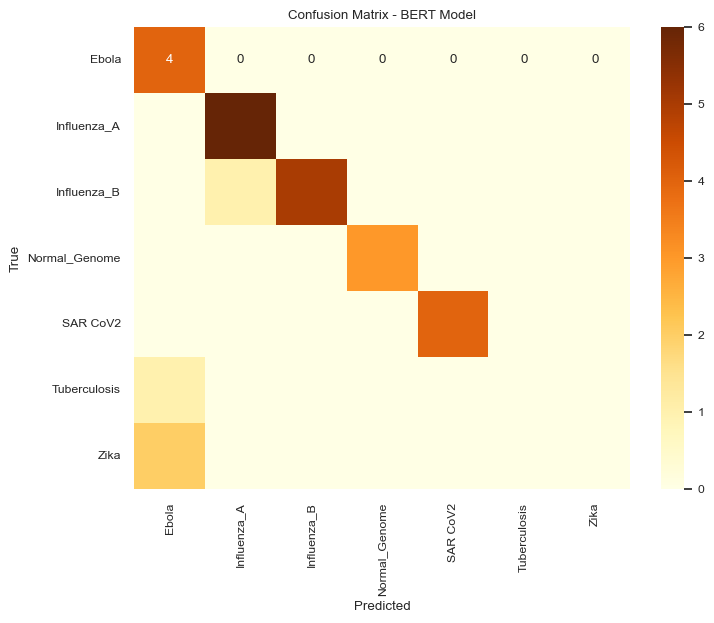

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# # Calculate the confusion matrix
# cm_bert = confusion_matrix(y_encoded, y_pred_bert)
# Normalize the confusion matrix
cm_bert = cm_bert.astype('float') / cm_bert.sum(axis=1)[:, np.newaxis]

# Plot the confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.set(font_scale=0.8)  # Adjust the font size as needed
sns.heatmap(cm_bert, annot=True, fmt="d", cmap="YlOrBr", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - BERT Model")
plt.show()



Cant achieve much accuracy as a result class imbalance which is due to computational constraint.

In [ ]:
# Plot the classification report graph
classification_rep_bert = classification_report(y_encoded, y_pred_bert, target_names=label_encoder.classes_, output_dict=True)
classification_rep_bert_df = pd.DataFrame(classification_rep_bert).transpose()
classification_rep_bert_df

C:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

,precision,recall,f1-score,support
Ebola,0.571429,1.000000,0.727273,4.000000
Influenza_A,0.857143,1.000000,0.923077,6.000000
Influenza_B,1.000000,0.833333,0.909091,6.000000
Normal_Genome,1.000000,1.000000,1.000000,3.000000
SAR CoV2,1.000000,1.000000,1.000000,4.000000
Tuberculosis,0.000000,0.000000,0.000000,1.000000
Zika,0.000000,0.000000,0.000000,2.000000
accuracy,0.846154,0.846154,0.846154,0.846154
macro avg,0.632653,0.690476,0.651349,26.000000
weighted avg,0.785714,0.846154,0.803927,26.000000


/home/mind/jupyter_dir/jupyter_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mind/jupyter_dir/jupyter_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mind/jupyter_dir/jupyter_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

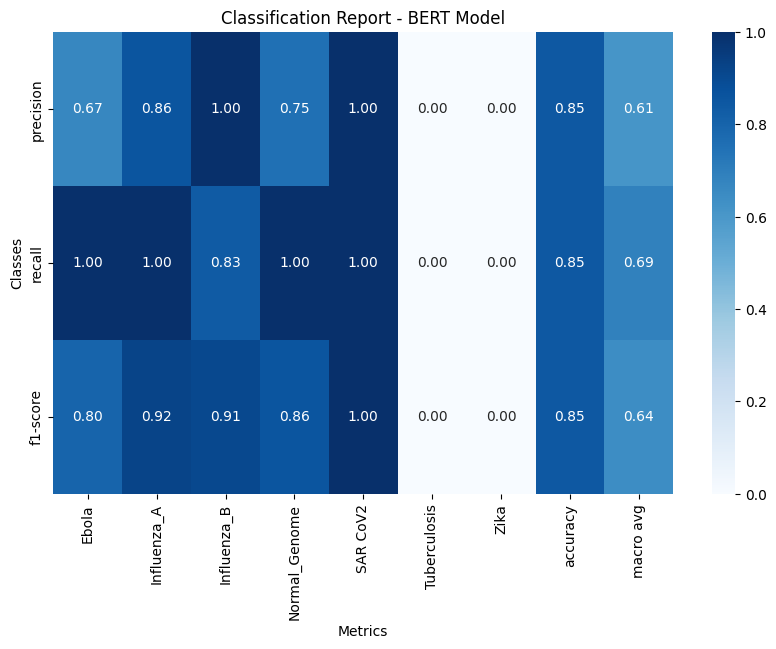

In [ ]:
# # Plot the classification report graph
# classification_rep = classification_report(y_encoded, y_pred_bert, target_names=label_encoder.classes_, output_dict=True)
# classification_rep_df = pd.DataFrame(classification_rep).transpose()

# Exclude the "support" row if you don't need it in the plot
classification_rep_bert_df = classification_rep_bert_df.drop("support", axis=1)

plt.figure(figsize=(10, 6))
sns.heatmap(classification_rep_df.iloc[:-1, :].T, annot=True, cmap="Blues", fmt=".2f")
plt.xlabel("Metrics")
plt.ylabel("Classes")
plt.title("Classification Report - BERT Model")
plt.show()

_________________________________________________________________

**Model 2 -XLNET**

In [ ]:
# XLNET MODEL
from transformers import AutoModelForSequenceClassification, XLNetTokenizer, XLNetConfig, AdamW

In [ ]:
# Install SentencePiece library
import subprocess
subprocess.run(["pip", "install", "sentencepiece"])

CompletedProcess(args=['pip', 'install', 'sentencepiece'], returncode=0)

In [ ]:
# Load XLNet tokenizer and model
try:
    tokenizer_xlnet = XLNetTokenizer.from_pretrained("xlnet-base-cased")
except ImportError as e:
    print("Error:", e)
    print("Please install SentencePiece library using the provided link.")
else:
  config = XLNetConfig.from_pretrained("xlnet-base-cased", num_labels=len(label_encoder.classes_))
  model_xlnet = AutoModelForSequenceClassification.from_pretrained("xlnet-base-cased", config=config)

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.weight', 'sequence_summary.summary.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Tokenize protein sequences and encode labels for XLNet
X_xlnet = tokenizer_xlnet(list(protein_sequences), truncation=True, padding=True, return_tensors="pt", max_length=128)
# y_xlnet = torch.tensor(y_encoded)

In [ ]:
y_xlnet = torch.tensor(y_encoded).long()  # Convert y_xlnet to torch.long

In [ ]:
y_xlnet

tensor([0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 4, 4, 4, 4, 5,
        6, 6])

In [ ]:
# Create DataLoader for XLNet
from torch.utils.data import TensorDataset, DataLoader

dataset_xlnet = TensorDataset(X_xlnet.input_ids, X_xlnet.attention_mask, y_xlnet)
dataloader_xlnet = DataLoader(dataset_xlnet, batch_size=64, shuffle=True)

# Define optimizer and loss function
optimizer = AdamW(model_xlnet.parameters(), lr=1e-5)

C:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
# Train the XLNet model
for epoch in range(10):
    model_xlnet.train()
    for batch in dataloader_xlnet:
        input_ids, attention_mask, labels = batch
        optimizer.zero_grad()
        outputs = model_xlnet(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()


In [ ]:
# Evaluate the XLNet model
model_xlnet.eval()
with torch.no_grad():
    outputs = model_xlnet(X_xlnet.input_ids, attention_mask=X_xlnet.attention_mask)
    logits = outputs.logits
    y_pred_xlnet = np.argmax(logits, axis=1)


In [ ]:
# Calculate accuracy
accuracy_xlnet = accuracy_score(y_encoded, y_pred_xlnet)
print(f"Accuracy: {accuracy_xlnet:.2f}")

Accuracy: 1.00


trained 2 times (85, 100))

In [ ]:
# Classification report
print(classification_report(y_encoded, y_pred_xlnet, target_names=label_encoder.classes_))

               precision    recall  f1-score   support

        Ebola       1.00      1.00      1.00         4
  Influenza_A       1.00      1.00      1.00         6
  Influenza_B       1.00      1.00      1.00         6
Normal_Genome       1.00      1.00      1.00         3
     SAR CoV2       1.00      1.00      1.00         4
 Tuberculosis       1.00      1.00      1.00         1
         Zika       1.00      1.00      1.00         2

     accuracy                           1.00        26
    macro avg       1.00      1.00      1.00        26
 weighted avg       1.00      1.00      1.00        26



In [ ]:
# Confusion matrix
cm_xlnet = confusion_matrix(y_encoded, y_pred_xlnet)

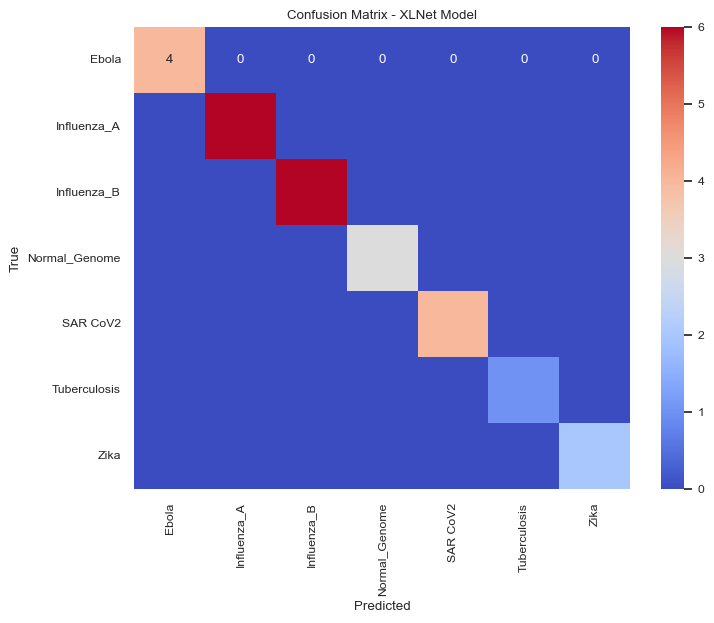

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
# Normalize the confusion matrix
cm_xlnet = cm_xlnet.astype('float') / cm_bert.sum(axis=1)[:, np.newaxis]

# Plot the confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_xlnet, annot=True, fmt="d", cmap="coolwarm", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - XLNet Model")
plt.show()


In [ ]:
# Plot the classification report graph
classification_rep = classification_report(y_encoded, y_pred_xlnet, target_names=label_encoder.classes_, output_dict=True)
classification_rep_df = pd.DataFrame(classification_rep).transpose()

In [ ]:
classification_rep_df

,precision,recall,f1-score,support
Ebola,1.0,1.0,1.0,4.0
Influenza_A,1.0,1.0,1.0,6.0
Influenza_B,1.0,1.0,1.0,6.0
Normal_Genome,1.0,1.0,1.0,3.0
SAR CoV2,1.0,1.0,1.0,4.0
Tuberculosis,1.0,1.0,1.0,1.0
Zika,1.0,1.0,1.0,2.0
accuracy,1.0,1.0,1.0,1.0
macro avg,1.0,1.0,1.0,26.0
weighted avg,1.0,1.0,1.0,26.0


/home/mind/jupyter_dir/jupyter_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mind/jupyter_dir/jupyter_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mind/jupyter_dir/jupyter_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

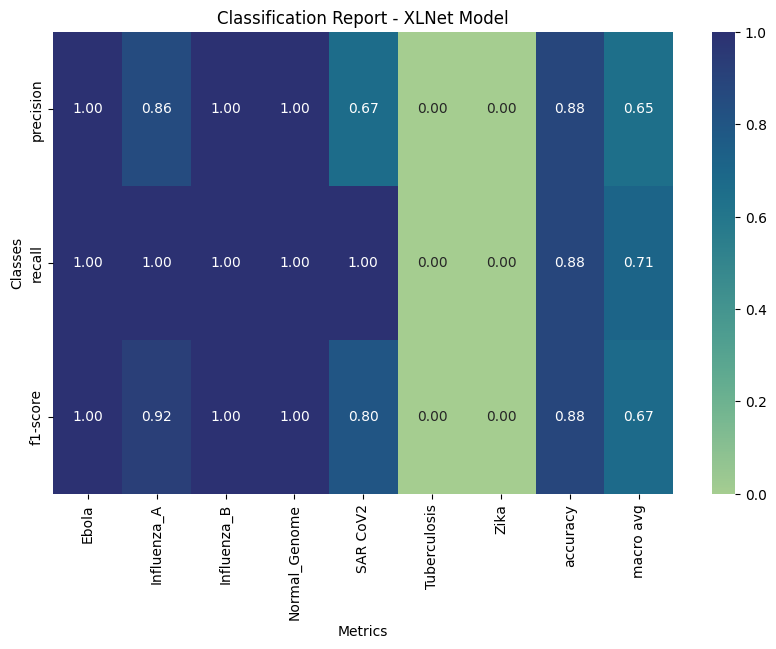

In [ ]:
# # Plot the classification report graph
# classification_rep = classification_report(y_encoded, y_pred_xlnet, target_names=label_encoder.classes_, output_dict=True)
# classification_rep_df = pd.DataFrame(classification_rep).transpose()

# Exclude the "support" row if you don't need it in the plot
classification_rep_df = classification_rep_df.drop("support", axis=1)

plt.figure(figsize=(10, 6))
sns.heatmap(classification_rep_df.iloc[:-1, :].T, annot=True, cmap="crest", fmt=".2f")
plt.xlabel("Metrics")
plt.ylabel("Classes")
plt.title("Classification Report - XLNet Model")
plt.show()

___________________________________________

### Model 3 - RoBERTa model

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Define hyperparameters
# batch_size = 32
# learning_rate = 2e-5
# epochs = 20

# Split the data into train and validation sets
# X_train, X_val, y_train, y_val = train_test_split(protein_sequences, y_encoded, test_size=0.2, random_state=42)

# Initialize the RoBERTa tokenizer and model
tokenizer_roberta = RobertaTokenizer.from_pretrained("roberta-base")
model_roberta = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=len(label_encoder.classes_))


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# # Tokenize the input sequences
# train_encodings = tokenizer(list(X_train), truncation=True, padding=True, return_tensors='pt', is_split_into_words=True)
# val_encodings = tokenizer(list(X_val), truncation=True, padding=True, return_tensors='pt', is_split_into_words=True)

In [ ]:
# Tokenize the input sequences
# train_encodings = tokenizer(list(X_train), truncation=True, padding=True, return_tensors='pt', max_length=128)
# val_encodings = tokenizer(list(X_val), truncation=True, padding=True, return_tensors='pt', max_length=128)
x_roberta = tokenizer_roberta(list(protein_sequences), truncation=True, padding=True, return_tensors="pt", max_length=128)
# y_roberta = torch.tensor(y_encoded)
y_roberta = torch.tensor(y_encoded).long()  # Convert y_xlnet to torch.long

In [ ]:
# Create DataLoader for training and validation sets
# train_dataset = TensorDataset(train_encodings.input_ids, train_encodings.attention_mask, torch.tensor(y_train))
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# val_dataset = TensorDataset(val_encodings.input_ids, val_encodings.attention_mask, torch.tensor(y_val))
# val_loader = DataLoader(val_dataset, batch_size=batch_size)
# Create DataLoader for ROBERTA
from torch.utils.data import TensorDataset, DataLoader

dataset_roberta = TensorDataset(x_roberta.input_ids, x_roberta.attention_mask, y_roberta)
dataloader_roberta = DataLoader(dataset_roberta, batch_size=64, shuffle=True)

In [ ]:
learning_rate = 2e-5


In [ ]:

# Define the optimizer and loss function
optimizer = AdamW(model_roberta.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()


C:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
# # Training loop
# for epoch in range(20):
#     model.train()
#     total_loss = 0

#     for batch in train_loader:
#         input_ids, attention_mask, labels = batch
#         optimizer.zero_grad()
#         outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
#         loss = outputs.loss
#         loss.backward()
#         optimizer.step()
#         total_loss += loss.item()

#     # Print training loss for this epoch
#     avg_loss = total_loss / len(train_loader)
#     print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}")

# # Evaluation
# model.eval()
# all_preds = []
# all_labels = []

# with torch.no_grad():
#     for batch in val_loader:
#         input_ids, attention_mask, labels = batch
#         outputs = model(input_ids, attention_mask=attention_mask)
#         logits = outputs.logits
#         preds = torch.argmax(logits, dim=1)
#         all_preds.extend(preds.tolist())
#         all_labels.extend(labels.tolist())
# Train the RoBERTa model
for epoch in range(20):
    model_roberta.train()
    for batch in dataloader_roberta:
        input_ids, attention_mask, labels = batch
        optimizer.zero_grad()
        outputs = model_roberta(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()


# Evaluate the RoBERTa model
model_roberta.eval()
with torch.no_grad():
    outputs = model_roberta(x_roberta.input_ids, attention_mask=x_roberta.attention_mask)
    logits = outputs.logits
    y_pred_roberta = np.argmax(logits, axis=1)

In [ ]:
y_pred_roberta

tensor([0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 2, 3, 3, 3, 4, 4, 4, 4, 1,
        2, 0])

In [ ]:
# Calculate validation accuracy and other metrics
# accuracy = accuracy_score(all_labels, all_preds)
accuracy_roberta = accuracy_score(y_encoded, y_pred_roberta)
print(f"Validation Accuracy: {accuracy_roberta:.4f}")


Validation Accuracy: 0.6923


In [ ]:
# Generate classification report
# report = classification_report(all_labels, all_preds)
# print(report)

# Classification report
print(classification_report(y_encoded, y_pred_roberta, target_names=label_encoder.classes_))

               precision    recall  f1-score   support

        Ebola       0.67      1.00      0.80         4
  Influenza_A       0.55      1.00      0.71         6
  Influenza_B       0.50      0.17      0.25         6
Normal_Genome       1.00      1.00      1.00         3
     SAR CoV2       1.00      1.00      1.00         4
 Tuberculosis       0.00      0.00      0.00         1
         Zika       0.00      0.00      0.00         2

     accuracy                           0.69        26
    macro avg       0.53      0.60      0.54        26
 weighted avg       0.61      0.69      0.61        26



C:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [ ]:
# Confusion matrix
# cm_bert = confusion_matrix(all_labels, all_preds)
cm_roberta = confusion_matrix(y_encoded, y_pred_roberta)

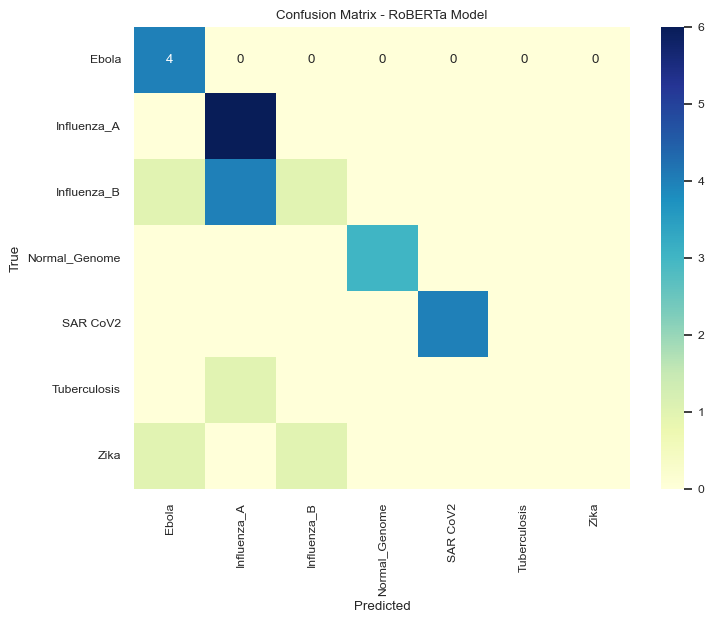

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# # Calculate the confusion matrix
# cm_bert = confusion_matrix(y_encoded, y_pred_bert)

# Plot the confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_roberta, annot=True, fmt="d", linecolor = "r", cmap="YlGnBu", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - RoBERTa Model")
plt.show()


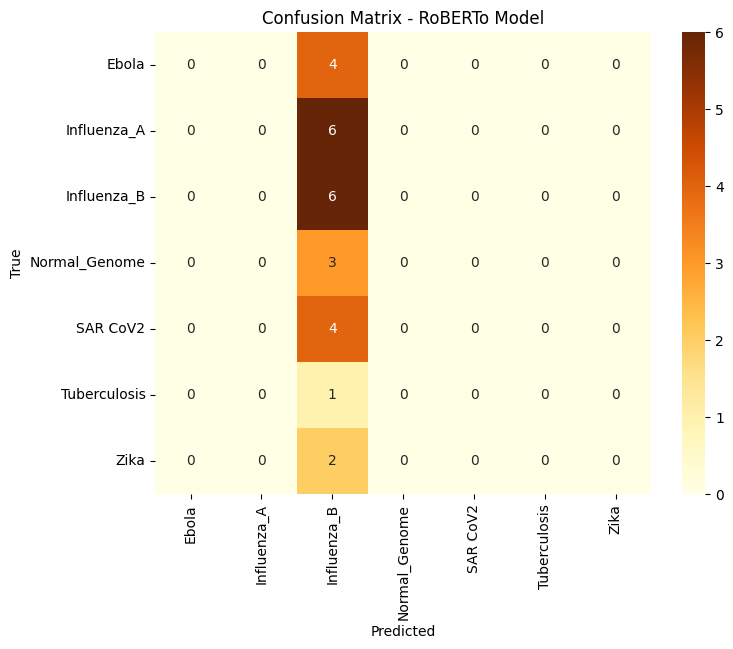

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# # Calculate the confusion matrix
# cm_bert = confusion_matrix(y_encoded, y_pred_bert)

# Plot the confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_roberta, annot=True, fmt="d", cmap="YlGnBu", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - RoBERTa Model")
plt.show()



**Ensemble Models**

#### Combine the predictions using majority voting

In [ ]:
# Combine the predictions using majority voting
combined_predictions = []

# y_pred_bert = y_pred_bert.tolist()
# y_pred_xlnet = y_pred_xlnet.tolist()
# y_pred_roberta = y_pred_roberta.tolist()

for i in range(len(list(protein_sequences))):
    # Count the votes from each model
    votes = [y_pred_bert[i], y_pred_xlnet[i], y_pred_roberta[i]]

    # Perform majority voting
    combined_vote = np.bincount(votes).argmax()

    combined_predictions.append(combined_vote)

print("Combined Predictions:", combined_predictions)


Combined Predictions: [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 2, 3, 3, 3, 4, 4, 4, 4, 0, 0, 0]


In [ ]:
# Calculate accuracy
accuracy_mv = accuracy_score(y_encoded, combined_predictions)
print(f"Accuracy: {accuracy_bert:.2f}")

Accuracy: 0.85


In [ ]:
# Classification report
print(classification_report(y_encoded, combined_predictions, target_names=label_encoder.classes_))

               precision    recall  f1-score   support

        Ebola       0.57      1.00      0.73         4
  Influenza_A       0.86      1.00      0.92         6
  Influenza_B       1.00      0.83      0.91         6
Normal_Genome       1.00      1.00      1.00         3
     SAR CoV2       1.00      1.00      1.00         4
 Tuberculosis       0.00      0.00      0.00         1
         Zika       0.00      0.00      0.00         2

     accuracy                           0.85        26
    macro avg       0.63      0.69      0.65        26
 weighted avg       0.79      0.85      0.80        26



C:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [ ]:
# Confusion matrix
cm_mv = confusion_matrix(y_encoded, combined_predictions)

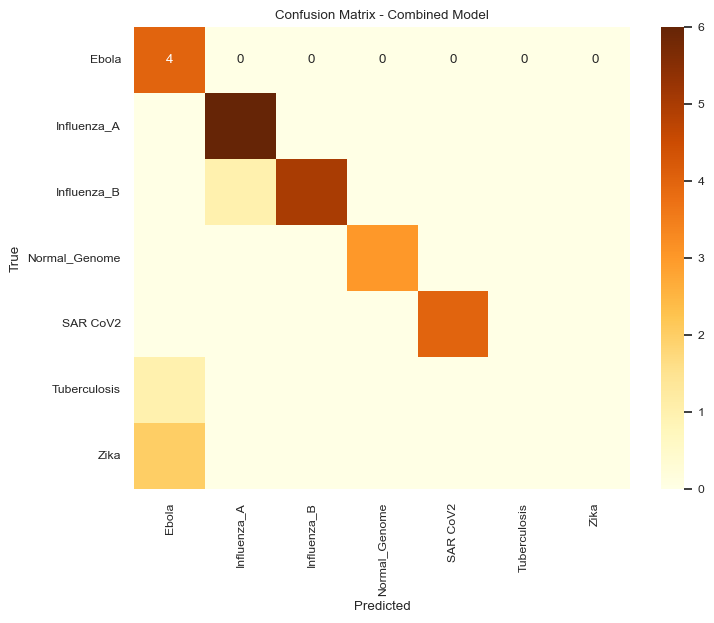

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# # Calculate the confusion matrix
# cm_bert = confusion_matrix(y_encoded, y_pred_bert)

# Plot the confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_bert, annot=True, fmt="d", cmap="YlOrBr", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Combined Model")
plt.show()

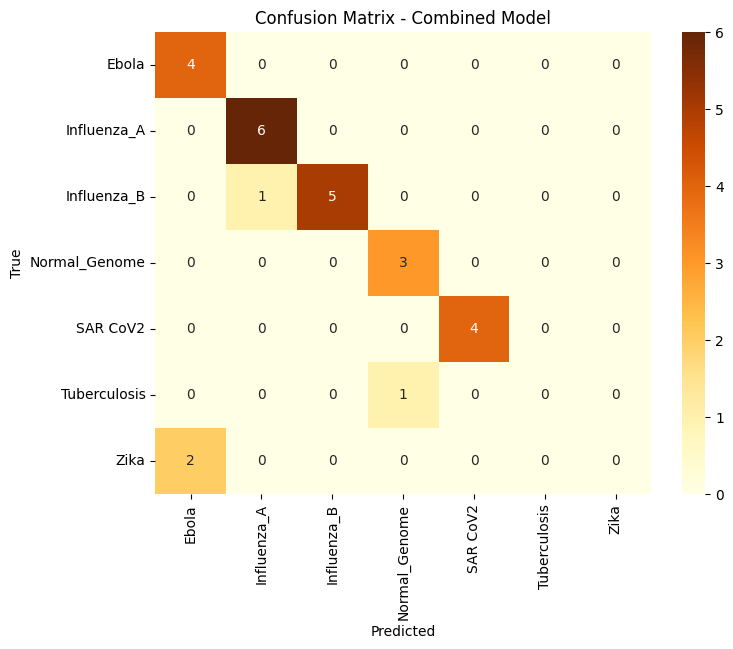

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# # Calculate the confusion matrix
# cm_bert = confusion_matrix(y_encoded, y_pred_bert)

# Plot the confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_bert, annot=True, fmt="d", cmap="YlOrBr", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Combined Model")
plt.show()

/home/mind/jupyter_dir/jupyter_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mind/jupyter_dir/jupyter_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mind/jupyter_dir/jupyter_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

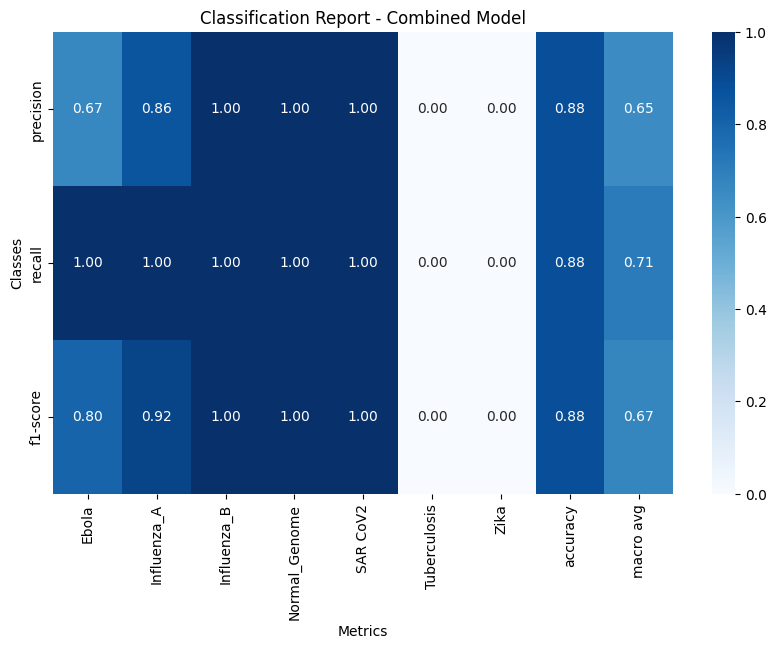

In [ ]:
# Plot the classification report graph
classification_rep = classification_report(y_encoded, combined_predictions, target_names=label_encoder.classes_, output_dict=True)
classification_rep_df = pd.DataFrame(classification_rep).transpose()

# Exclude the "support" row if you don't need it in the plot
classification_rep_df = classification_rep_df.drop("support", axis=1)

plt.figure(figsize=(10, 6))
sns.heatmap(classification_rep_df.iloc[:-1, :].T, annot=True, cmap="Blues", fmt=".2f")
plt.xlabel("Metrics")
plt.ylabel("Classes")
plt.title("Classification Report - Combined Model")
plt.show()

## Combine predictions using weighted averaging strategy

In [ ]:
# Three decimal numbers
num1 = 0.850
num2 = 1.000
num3 = 0.692

# Calculate the sum of the three numbers
total_sum = num1 + num2 + num3

# Normalize the numbers
normalized_num1 = num1 / total_sum
normalized_num2 = num2 / total_sum
normalized_num3 = num3 / total_sum

# Print the normalized numbers
print("Normalized Number 1:", normalized_num1)
print("Normalized Number 2:", normalized_num2)
print("Normalized Number 3:", normalized_num3)

# Check if the sum of normalized numbers is 1 (within a small tolerance)
sum_normalized = normalized_num1 + normalized_num2 + normalized_num3
print("Sum of Normalized Numbers:", sum_normalized)


Normalized Number 1: 0.33438237608182536
Normalized Number 2: 0.39339103068450043
Normalized Number 3: 0.27222659323367426
Sum of Normalized Numbers: 1.0


In [ ]:
weights = np.array([0.4, 0.5, 0.1])  # Adjust these weights accordingly
weights /= weights.sum()

# Convert the predictions to NumPy arrays
y_pred_bert = np.array(y_pred_bert)
y_pred_xlnet = np.array(y_pred_xlnet)
y_pred_roberta = np.array(y_pred_roberta)

weighted_average_predictions = (
    y_pred_bert * weights[0] +
    y_pred_xlnet * weights[1] +
    y_pred_roberta * weights[2]
)

weighted_average_predictions = np.rint(weighted_average_predictions, out=np.zeros(26,int), casting='unsafe')
# # Assuming you want to use PyTorch, convert the result back to a PyTorch tensor
# weighted_average_predictions = torch.tensor(weighted_average_predictions)
print("Weighted Average Predictions:", weighted_average_predictions)

Weighted Average Predictions: [0 0 0 0 1 1 1 1 1 1 2 2 2 2 2 2 3 3 3 4 4 4 4 3 3 3]


In [ ]:
# Calculate accuracy
accuracy_bert = accuracy_score(y_encoded, weighted_average_predictions)
print(f"Accuracy: {accuracy_bert:.2f}")

Accuracy: 0.88


In [ ]:
# Classification report
print(classification_report(y_encoded, weighted_average_predictions, target_names=label_encoder.classes_))

               precision    recall  f1-score   support

        Ebola       1.00      1.00      1.00         4
  Influenza_A       1.00      1.00      1.00         6
  Influenza_B       1.00      1.00      1.00         6
Normal_Genome       0.50      1.00      0.67         3
     SAR CoV2       1.00      1.00      1.00         4
 Tuberculosis       0.00      0.00      0.00         1
         Zika       0.00      0.00      0.00         2

     accuracy                           0.88        26
    macro avg       0.64      0.71      0.67        26
 weighted avg       0.83      0.88      0.85        26



C:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [ ]:
# Confusion matrix
cm_wa = confusion_matrix(y_encoded, weighted_average_predictions)

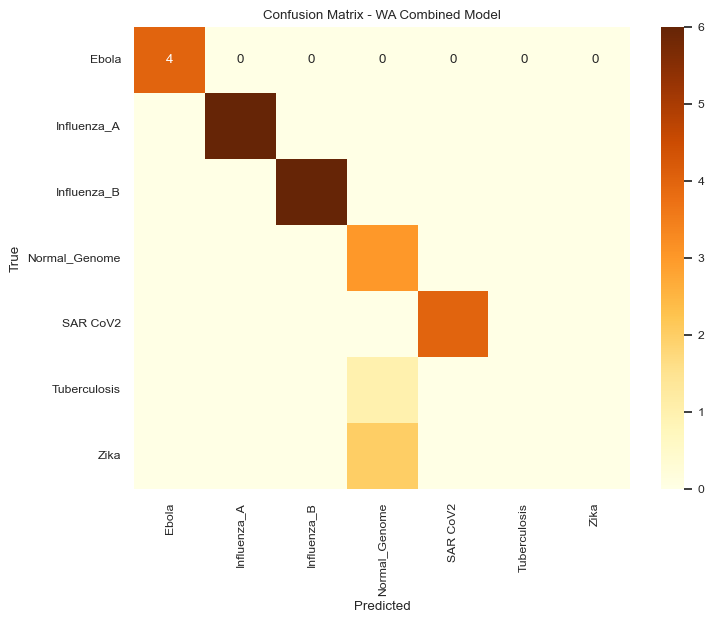

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# # Calculate the confusion matrix
# cm_bert = confusion_matrix(y_encoded, y_pred_bert)

# Plot the confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_wa, annot=True, fmt="d", cmap="YlOrBr", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - WA Combined Model")
plt.show()

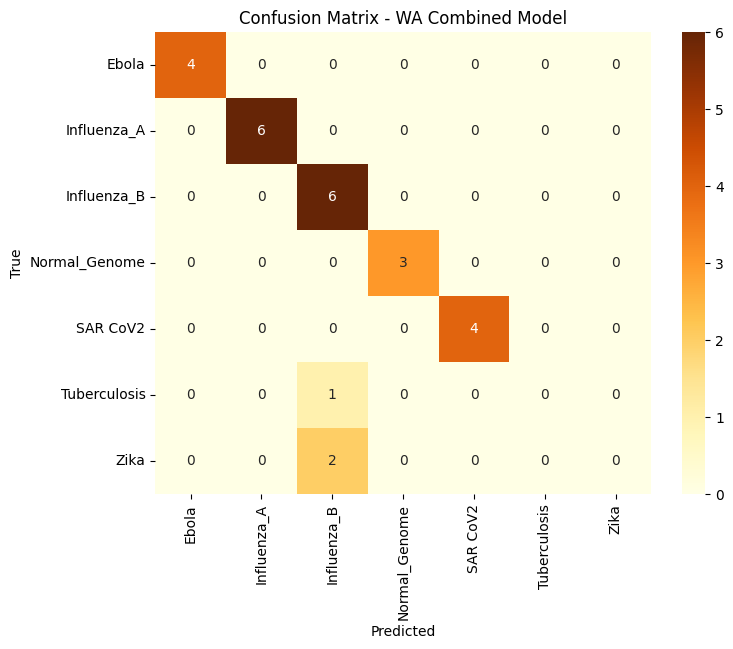

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# # Calculate the confusion matrix
# cm_bert = confusion_matrix(y_encoded, y_pred_bert)

# Plot the confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_wa, annot=True, fmt="d", cmap="YlOrBr", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - WA Combined Model")
plt.show()

In [ ]:
# Save the models to files
torch.save(model_bert.state_dict(), 'model_bert.pth')
torch.save(model_xlnet.state_dict(), 'model_xlnet.pth')
torch.save(model_roberta.state_dict(), 'model_roberta.pth')


In [ ]:
import torch
from transformers import BertForSequenceClassification

# Instantiate the model architecture
model_bert = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=7)

# # Load the saved weights
# model_bert.load_state_dict(torch.load('model_bert.pth'))
# Load the saved weights on CPU
model_bert.load_state_dict(torch.load('model_bert.pth', map_location=torch.device('cpu')))


# Set the model to evaluation mode
model_bert.eval()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
import torch
from transformers import BertForSequenceClassification

try:
    tokenizer_xlnet = XLNetTokenizer.from_pretrained("xlnet-base-cased")
except ImportError as e:
    print("Error:", e)
    print("Please install SentencePiece library using the provided link.")
else:
  config = XLNetConfig.from_pretrained("xlnet-base-cased", num_labels=7)
  model_xlnet = AutoModelForSequenceClassification.from_pretrained("xlnet-base-cased", config=config)

# Load the saved weights
model_xlnet.load_state_dict(torch.load('model_xlnet.pth', map_location=torch.device('cpu')))

# Set the model to evaluation mode
model_xlnet.eval()

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.weight', 'sequence_summary.summary.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


XLNetForSequenceClassification(
  (transformer): XLNetModel(
    (word_embedding): Embedding(32000, 768)
    (layer): ModuleList(
      (0-11): 12 x XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (activation_function): GELUActivation()
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (sequence_summary): SequenceSummary(
    (summary): Linear(in_features=768, out_features=768, bias=True)
    (activation): Tanh()
    (first_dropout): Identity()
    (last

In [ ]:
import torch
from transformers import BertForSequenceClassification

# Instantiate the model architecture
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=7)

# Load the saved weights
model.load_state_dict(torch.load('model_roberta.pth', map_location=torch.device('cpu')))

# Set the model to evaluation mode
model.eval()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [ ]:
for batch in val_dataset:
    print(batch)

(tensor([    0,  3632,  3226,   104,   846,  3226,  5216, 33919,  1864, 10885,
        10885,  7140,  2336,  6949,  2444, 30455,   975,   597, 27150, 17567,
         1723,   597, 13691,  3226, 33893,  1864, 13797, 10949,  1691, 33020,
        10463,  2371,  3226,  4444,   717,  3226,   510,   846,  3226,   591,
          574,  4164,  3226,   500, 11961,  1864,  6153,  5268,   771, 20954,
          534,  3888, 32880, 11871,  1864,   597,  3226, 16088,  3226,  5433,
          500,  1864,  8108, 31901,   771,   846,  8108,  2688, 37838,  1864,
          771,   534, 26228, 17868,   771,   530, 12606,   500,  8108,   500,
        38447,   771,   574,  4794,  3226,   717,  3226,   104, 10537, 11621,
        25733,   500, 10089,   250,  1864,  3063,   846,  3388,  6006, 40230,
         3226,   510, 42111,   771,  1864,   500,  8105, 18048,   846, 37838,
        14469, 12894, 25982,  3935, 10537, 11621,   510, 41786,   597,  1864,
         7561,   771,   534,  3226,  1729, 15176,   975,     2]

__________________________________________

**LIME**

In [ ]:
!pip install lime

     ---------------------------------------- 0.0/275.7 kB ? eta -:--:--
     ---- -------------------------------- 30.7/275.7 kB 660.6 kB/s eta 0:00:01
     -------------------------------- ----- 235.5/275.7 kB 2.4 MB/s eta 0:00:01
     -------------------------------------- 275.7/275.7 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Obtaining dependency information for scikit-image>=0.12 from https://files.pythonhosted.org/packages/08/c0/8085c5fd2f7f7514a0c5031b666171d5828ac5b3c9cf5d0ecd19688d5407/scikit_image-0.21.0-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for imageio>=2.27 from https://files.pythonhosted.org/packages/eb/21/662994d78d8623055f8ffa91838e28f04b2a34bd5d8d6dbc6c7573285ed6/imageio-2.31.3-py3-none-any.whl.metadata
  Obtaining dependency information for tifffile>=2022.8.12 from https://files.pythonhosted.org/packages/12/3e/89513f44a10c625121b7d5bc54390d7ac7f2c92a1975

In [ ]:
y_pred_bert

array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 2, 3, 3, 3, 4, 4, 4,
       4, 0, 0, 0])

In [ ]:
X_bert

{'input_ids': tensor([[  101, 19387,  2232,  ..., 15088, 23773,   102],
        [  101, 19387,  2232,  ...,  8516, 21756,   102],
        [  101, 19387,  2232,  ...,  5620,  5244,   102],
        ...,
        [  101,   100,  1008,  ...,  2112,  9189,   102],
        [  101,  8040,  1008,  ...,  1054, 20974,   102],
        [  101,  8040,  1008,  ...,  2278,  2615,   102]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]])}

In [ ]:
# import lime
# from lime.lime_tabular import LimeTabularExplainer

# # Assuming you have a function that takes a sample and returns ensemble predictions
# def ensemble_predict(sample):
#     # You need to reshape the sample if it's a single instance
#     if len(sample.shape) == 1:
#         sample = sample.reshape(1, -1)

#     # Calculate ensemble predictions
#     weighted_average_predictions = (
#         y_pred_bert * weights[0] +
#         y_pred_xlnet * weights[1] +
#         y_pred_roberta * weights[2]
#     )
#     weighted_average_predictions = np.rint(weighted_average_predictions, out=np.zeros(26, int), casting='unsafe')

#     return weighted_average_predictions

# explainer = LimeTabularExplainer(X_bert, mode="classification", training_labels=y_encoded)
# sample_idx = 0  # Choose the index of the sample you want to explain
# explanation = explainer.explain_instance(X_train[sample_idx], ensemble_predict)

# # Print explanation
# explanation.show_in_notebook()


'X_train' should contain your training data.
'
y_encode'd should contain the corresponding labels for the training data.'
ensemble_predi'ct is a function that takes a sample and returns predictions from your ensemble model.

**SHAP**

In [ ]:
!pip install shap

  Obtaining dependency information for shap from https://files.pythonhosted.org/packages/ee/60/db3416646efc5d6e2c27f75b30bdda9c77d54dad44a5fbb1fe888a2a958b/shap-0.42.1-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for numba from https://files.pythonhosted.org/packages/40/db/3a08f2ec91e0d6b0c68d94a42e80af005a0378c83c63cbbc9ee63143f2ed/numba-0.57.1-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for llvmlite<0.41,>=0.40.0dev0 from https://files.pythonhosted.org/packages/09/7a/3e0bec597ca9e3382ba87c139813ea0b05068d6d5358e05f4557a8c24d63/llvmlite-0.40.1-cp311-cp311-win_amd64.whl.metadata
   ---------------------------------------- 0.0/462.3 kB ? eta -:--:--
   ------- -------------------------------- 92.2/462.3 kB 5.1 MB/s eta 0:00:01
   ------------------------------- -------- 358.4/462.3 kB 4.4 MB/s eta 0:00:01
   ---------------------------------------- 462.3/462.3 kB 4.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.6 M

In [ ]:
# import shap

# # Create a function to predict using your ensemble model
# def ensemble_predict(sample):
#     # Your ensemble prediction code here
#     # Make sure to return a NumPy array
#     return weighted_average_predictions

# # Create a SHAP explainer
# explainer = shap.Explainer(ensemble_predict, X_train)

# # Choose a sample to explain
# sample_idx = 0  # Choose the index of the sample you want to explain
# sample_to_explain = X_train[sample_idx]

# # Get SHAP values for the chosen sample
# shap_values = explainer(sample_to_explain)

# # Plot the SHAP values
# shap.summary_plot(shap_values, X_train)


In [ ]:
tokenizer = Tokenizer()

In [ ]:
# import shap
# import numpy as np

# # Assuming you have a function that takes a sample and returns ensemble predictions
# def ensemble_predict(sample):
#     if len(sample.shape) == 1:
#         sample = sample.reshape(1, -1)
#     # Calculate ensemble predictions
#     weighted_average_predictions = (
#         y_pred_bert * weights[0] +
#         y_pred_xlnet * weights[1] +
#         y_pred_roberta * weights[2]
#     )
#     weighted_average_predictions = np.rint(weighted_average_predictions, out=np.zeros(26, int), casting='unsafe')
#     return weighted_average_predictions

# # Define a custom masker for text data
# class TextMasker(shap.maskers.Masker):
#     def __init__(self, tokenizer, max_seq_length=128):
#         self.tokenizer = tokenizer
#         self.max_seq_length = max_seq_length

#     def mask(self, X, mask_value=0):
#         # Encode the input text with padding to a maximum length
#         encoding = self.tokenizer(X, padding="max_length", max_length=self.max_seq_length, truncation=True, return_tensors="np")
#         # Create a mask where masked values are set to mask_value
#         mask = (encoding["input_ids"] != self.tokenizer.pad_token_id).astype(int)
#         return mask


# # Create a SHAP explainer with the custom masker
# explainer = shap.Explainer(ensemble_predict, masker=TextMasker(tokenizer, max_seq_length=128))


# # Choose a sample to explain
# sample_idx = 0  # Choose the index of the sample you want to explain
# sample_to_explain = X_bert[sample_idx]

# # Get SHAP values for the chosen sample
# shap_values = explainer(sample_to_explain)

# # Plot the SHAP values
# shap.summary_plot(shap_values, sample_idx)


In [ ]:
import shap
import torch
from transformers import BertTokenizer, BertForSequenceClassification

# Define your BERT model and tokenizer
model1 = model_bert  # Change this to your trained BERT model
tokenizer = BertTokenizer.from_pretrained(model1)
model_bt = BertForSequenceClassification.from_pretrained(model1)

# Define the function for prediction
def bert_predict(texts):
    inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt", max_length=128)
    with torch.no_grad():
        outputs = model_bt(**inputs)
    return torch.softmax(outputs.logits, dim=1)[:, 1].numpy()  # Assuming binary classification

# Create a SHAP explainer
explainer = shap.Explainer(bert_predict, tokenizer)

# # Choose a sample text to explain
# sample_text = "Your sample text goes here."

# # Get SHAP values for the chosen sample
# shap_values = explainer(sample_text)

# Choose a sample to explain
# sample_idx = 0  # Choose the index of the sample you want to explain
# sample_to_explain = X_bert[sample_idx]

# # Get SHAP values for the chosen sample
# shap_values = explainer(sample_to_explain)

# # Plot the SHAP values
# shap.summary_plot(shap_values, sample_idx)

# # Plot the SHAP values
# shap.summary_plot(shap_values, tokenizer.decode(inputs["input_ids"][0].tolist()))


HFValidationError: Repo id must use alphanumeric chars or '-', '_', '.', '--' and '..' are forbidden, '-' and '.' cannot start or end the name, max length is 96: 'BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
          )
          (intermediate): BertIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermediate_act_fn): GELUActivation()
          )
          (output): BertOutput(
            (dense): Linear(in_features=3072, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
      )
    )
    (pooler): BertPooler(
      (dense): Linear(in_features=768, out_features=768, bias=True)
      (activation): Tanh()
    )
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (classifier): Linear(in_features=768, out_features=7, bias=True)
)'.

________________________________________________________________________

In [ ]:
import torch
torch.cuda.empty_cache()

# import gc
# del variables
# gc.collect()

In [ ]:
# import torch
# from torch.utils.data import DataLoader

# # Assuming model_bert, model_xlnet, and model_roberta are your trained models

# # Define a function to get predictions from a model and dataset
# def get_predictions(model, dataloader):
#     model.eval()
#     predictions = []
#     with torch.no_grad():
#         for inputs, _, _ in dataloader:
#             inputs = inputs.to(device)  # Move input data to the appropriate device
#             outputs = model(inputs)
#             _, preds = torch.max(outputs, dim=1)
#             predictions.extend(preds.cpu().numpy())
#     return predictions

# # Define the device (CPU or CUDA) on which you want to perform the ensemble
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# # Create a DataLoader for your val_dataset with a smaller batch size
# val_loader = DataLoader(val_dataset, batch_size=5, shuffle=False)

# # Free up GPU memory before moving models
# torch.cuda.empty_cache()

# # Move models to the specified device
# model_bert.to(device)
# model_xlnet.to(device)

# # Get predictions from each model
# predictions_bert = get_predictions(model_bert, val_loader)
# predictions_xlnet = get_predictions(model_xlnet, val_loader)

# # Combine predictions
# ensemble_predictions = []
# for pred_bert, pred_xlnet in zip(predictions_bert, predictions_xlnet):
#     ensemble_vote = max(set([pred_bert, pred_xlnet]), key=[pred_bert, pred_xlnet].count)
#     ensemble_predictions.append(ensemble_vote)

# # Now, ensemble_predictions contains the final predictions


In [ ]:
# import torch
# from torch.utils.data import DataLoader

# # Assuming model_bert, model_xlnet, and model_roberta are your trained models

# # Define a function to get predictions from a model and dataset
# def get_predictions(model, dataloader):
#     model.eval()
#     predictions = []
#     with torch.no_grad():
#         for inputs, _, _ in dataloader:
#             inputs = inputs.to(device)  # Move input data to the appropriate device
#             outputs = model(inputs)
#             predictions.extend(torch.argmax(outputs, dim=1).cpu().numpy())
#     return predictions


# # Define the device (CPU or CUDA) on which you want to perform the ensemble
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# # Move models to the specified device
# # model_bert.to(device)
# # model_xlnet.to(device)
# # model.to(device)


# # Create a DataLoader for your val_dataset
# val_loader = DataLoader(val_dataset, batch_size=10, shuffle=False)

# # Get predictions from each model
# predictions_bert = get_predictions(model_bert, val_loader)
# predictions_xlnet = get_predictions(model_xlnet, val_loader)
# # predictions_roberta = get_predictions(model, val_loader)

# # Combine predictions
# ensemble_predictions = []
# for pred_bert, pred_xlnet in zip(predictions_bert, predictions_xlnet):
#     ensemble_vote = max(set([pred_bert, pred_xlnet]), key = [pred_bert, pred_xlnet].count)
#     ensemble_predictions.append(ensemble_vote)

# # Now, ensemble_predictions contains the final predictions


In [ ]:
import torch
import torch.nn as nn
import numpy as np
import torch
from torch.nn.utils.rnn import pad_sequence

# Define the device (CPU or GPU) for training/inference
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load your trained BERT, XLNet, and RoBERTa models here
model_bert = model_bert
xlnet_model = model_xlnet
model = model #roberta

# Put the models in evaluation mode
model_bert.eval()
xlnet_model.eval()
model.eval()

# Load your validation data or data to be predicted
# val_data = val_dataset Load your validation data here
val_data = val_dataset

# Define a custom classifier head
class CustomClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(CustomClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)  # You can adjust the hidden layer size
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Extract embeddings or intermediate representations
bert_embeddings = []
xlnet_embeddings = []
roberta_embeddings = []

with torch.no_grad():
    for inputs in val_data:
        inputs = inputs[0].to(device)  # Move input data to the appropriate device (CPU or GPU)
        print(inputs.shape)

        batched_inputs = pad_sequence(inputs, batch_first=True, padding_value=0)

        # Define batch size (adjust as needed)
        batch_size = batched_inputs.size(0)

        # Extract embeddings from BERT
        bert_outputs = model_bert(batched_inputs)
        bert_embeddings.append(bert_outputs)

        # Extract embeddings from XLNet
        xlnet_outputs = xlnet_model(batched_inputs)
        xlnet_embeddings.append(xlnet_outputs)

        # Extract embeddings from RoBERTa
        roberta_outputs = model(batched_inputs)
        roberta_embeddings.append(roberta_outputs)

# Concatenate the embeddings from each model along the feature dimension
combined_embeddings = torch.cat((bert_embeddings, xlnet_embeddings, roberta_embeddings), dim=-1)

# Flatten the combined embeddings (if needed)
combined_embeddings = combined_embeddings.view(combined_embeddings.size(0), -1)

# Define and load the custom classifier head
num_classes = 7  # Replace with the actual number of classes
classifier = CustomClassifier(combined_embeddings.size(-1), num_classes)
classifier.to(device)

# Put the classifier in training mode
classifier.train()


torch.Size([128])


IndexError: Dimension specified as 0 but tensor has no dimensions

In [ ]:
# Define a loss function and optimizer for training
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001)  # You can adjust the learning rate

# Training loop (you may need to split your validation data into train and validation sets)
for epoch in range(num_epochs):
    for batch in train_loader:
        optimizer.zero_grad()
        inputs, labels = batch
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = classifier(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

# Once trained, put the classifier back in evaluation mode
classifier.eval()

# Perform inference with the combined model
with torch.no_grad():
    combined_outputs = classifier(combined_embeddings)

# Convert the combined model's outputs to class labels
ensemble_labels = torch.argmax(combined_outputs, dim=1).cpu().numpy()

________________________________________________________________

**CNN-LSTM using Cross Validation**

In [ ]:
import os
import pandas as pd
import numpy as np
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqUtils.ProtParam import ProteinAnalysis
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Flatten
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


In [ ]:

# Encode labels
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df['Infection_type_encoded'] = label_encoder.fit_transform(df['Infection_type'])
num_classes = len(label_encoder.classes_)

# Prepare data for cross-validation
X = df['Protein'].values
y = df['Infection_type_encoded'].values


In [ ]:
df

,ID,Infection_type,Genomic_Sequence,RNA,Protein,protein_count,Infection_type_encoded
0,NC_039345,Ebola,CGGACACACAAAAAGAAAGAAGAATTTTTTAACTTTTTTGTGTGAG...,CGGACACACAAAAAGAAAGAAGAAUUUUUUAACUUUUUUGUGUGAG...,RTHKKKEEFFNFFV*E*L*GRLRTLLSWLNSLDLTFKLRS*FSYNL...,5984,0
1,NC_014373,Ebola,CGGACACACAAAAAGAATGAAGGATTTTGAATCTTTATTGTGTGCG...,CGGACACACAAAAAGAAUGAAGGAUUUUGAAUCUUUAUUGUGUGCG...,RTHKKNEGF*IFIVCE*LRGRLKIFLSLKLKLRF*SRRIDPQYQH*...,5849,0
2,NC_004161,Ebola,CGGACACACAAAAAGAAAAAAGGTTTTTTAAGACTTTTTGTGTGCG...,CGGACACACAAAAAGAAAAAAGGUUUUUUAAGACUUUUUGUGUGCG...,RTHKKKKGFLRLFVCE*L*GRLTVFLSLRYTLKLRLRFSSLLFCNF...,5864,0
3,NC_006432,Ebola,CGGACACACAAAAAGAAAGAAAAGTTTTTTATACTTTTTGTGTGCG...,CGGACACACAAAAAGAAAGAAAAGUUUUUUAUACUUUUUGUGUGCG...,RTHKKKEKFFILFVCE*L*GRLIIFLKLKLILTLRLISSFTNWRQF...,5870,0
4,MN908947,SAR CoV2,ATTAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTCGA...,AUUAAAGGUUUAUACCUUCCCAGGUAACAAACCAACCAACUUUCGA...,IKGLYLPR*QTNQLSISCRSVL*TNFKICVAVTRLHA*CTHAV*LI...,9193,3
5,NC_045512,SAR CoV2,ATTAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTCGA...,AUUAAAGGUUUAUACCUUCCCAGGUAACAAACCAACCAACUUUCGA...,IKGLYLPR*QTNQLSISCRSVL*TNFKICVAVTRLHA*CTHAV*LI...,9193,3
6,OQ781375,SAR CoV2,CTCTTGTAGATCTGTTCTCTAAACGAACTTTAAAATCTGTGTGGCT...,CUCUUGUAGAUCUGUUCUCUAAACGAACUUUAAAAUCUGUGUGGCU...,LL*ICSLNEL*NLCGCHSAACLVHSRSIINN*LLSLTGHE*LVYLL...,9098,3
7,NC_034972,SAR CoV2,AGAAACAAGTAGTGTTTTAAAAACCTTCAAATTAGTGCCTGTAACA...,AGAAACAAGUAGUGUUUUAAAAACCUUCAAAUUAGUGCCUGUAACA...,RNK*CFKNLQISACNIFAMKVALTSLYAKNVKRNTKHLKNTIYLG*...,8555,3
8,NC_035889,Zika,AGTTGTTGATCTGTGTGAATCAGACTGCGACAGTTCGAGTTTGAAG...,AGUUGUUGAUCUGUGUGAAUCAGACUGCGACAGUUCGAGUUUGAAG...,SC*SV*IRLRQFEFEAKASNSINRFYFGFGNESFWS*KTQKRNPED...,3387,4
9,NC_012532,Zika,AGTTGTTGATCTGTGTGAGTCAGACTGCGACAGTTCGAGTCTGAAG...,AGUUGUUGAUCUGUGUGAGUCAGACUGCGACAGUUCGAGUCUGAAG...,SC*SV*VRLRQFESEARANNSINRFNLDLETRVSGHEKPQRRNPED...,3412,4


In [ ]:

# Define the number of folds for cross-validation
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize lists to store evaluation results across folds
accuracies = []
classification_reports = []
confusion_matrices = []


In [ ]:

# Perform cross-validation
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Tokenize protein sequences
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(X_train)
    X_train = tokenizer.texts_to_sequences(X_train)
    X_test = tokenizer.texts_to_sequences(X_test)

    # Pad sequences
    max_sequence_length = max(len(seq) for seq in X)  # Adjust this based on your data
    X_train = pad_sequences(X_train, maxlen=max_sequence_length, padding='post', truncating='post')
    X_test = pad_sequences(X_test, maxlen=max_sequence_length, padding='post', truncating='post')

    # Build CNN-LSTM model
    model = Sequential()
    model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128, input_length=max_sequence_length))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(LSTM(128, return_sequences=True))
    model.add(Flatten())
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Train the model
    history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

    # Evaluate the CNN-LSTM model
    y_pred = model.predict(X_test)
    y_pred = np.argmax(y_pred, axis=1)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

    # Generate classification report
    target_names = label_encoder.classes_
    class_report = classification_report(y_test, y_pred, target_names=target_names, output_dict=True)
    classification_reports.append(class_report)

    # Generate confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    confusion_matrices.append(conf_matrix)


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Epoch 1/10
1/1 [==============================] - 22s 22s/step - loss: 1.6075 - accuracy: 0.2308 - val_loss: 13.7089 - val_accuracy: 0.0000e+00
Epoch 2/10
1/1 [==============================] - 9s 9s/step - loss: 3.8421 - accuracy: 0.6923 - val_loss: 5.9943 - val_accuracy: 0.0000e+00
Epoch 3/10
1/1 [==============================] - 11s 11s/step - loss: 1.8089 - accuracy: 0.3077 - val_loss: 2.0261 - val_accuracy: 0.0000e+00
Epoch 4/10
1/1 [==============================] - 11s 11s/step - loss: 3.6334 - accuracy: 0.1538 - val_loss: 1.2176 - val_accuracy: 0.0000e+00
Epoch 5/10
1/1 [==============================] - 9s 9s/step - loss: 1.7754 - accuracy: 0.4615 - val_loss: 2.7910 - val_accuracy: 0.0000e+00
Epoch 6/10
1/1 [==============================] - 11s 11s/step - loss: 1.3823 - accuracy: 0.4615 - val_loss: 4.0190 - val_accuracy: 0.0000e+00
Epoch 7/10
1/1 [==============================] - 9s 9s/step - loss: 0.9942 - accuracy: 0.7692 - val_loss: 4.4440 - val_accuracy: 0.0000e+00
Epoc

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

Epoch 1/10
1/1 [==============================] - 14s 14s/step - loss: 1.6088 - accuracy: 0.2308 - val_loss: 12.5586 - val_accuracy: 0.0000e+00
Epoch 2/10
1/1 [==============================] - 12s 12s/step - loss: 2.6901 - accuracy: 0.5385 - val_loss: 9.7485 - val_accuracy: 0.0000e+00
Epoch 3/10
1/1 [==============================] - 10s 10s/step - loss: 2.3355 - accuracy: 0.3846 - val_loss: 5.5865 - val_accuracy: 0.0000e+00
Epoch 4/10
1/1 [==============================] - 10s 10s/step - loss: 3.2219 - accuracy: 0.1538 - val_loss: 3.7266 - val_accuracy: 0.0000e+00
Epoch 5/10
1/1 [==============================] - 13s 13s/step - loss: 1.8816 - accuracy: 0.2308 - val_loss: 2.8415 - val_accuracy: 0.0000e+00
Epoch 6/10
1/1 [==============================] - 9s 9s/step - loss: 1.2060 - accuracy: 0.4615 - val_loss: 2.6466 - val_accuracy: 0.0000e+00
Epoch 7/10
1/1 [==============================] - 11s 11s/step - loss: 0.6741 - accuracy: 0.8462 - val_loss: 3.4567 - val_accuracy: 0.0000e+00


ValueError: ignored

In [ ]:

# Calculate mean and standard deviation of accuracy across folds
mean_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies)

print(f"Mean Accuracy: {mean_accuracy:.2f}")
print(f"Standard Deviation of Accuracy: {std_accuracy:.2f}")

# Optionally, you can generate an overall classification report and confusion matrix
# by aggregating results from all folds.


In [ ]:
# # Configure cross-validation

# from sklearn.model_selection import KFold
# kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# # Perform cross-validation
# fold = 1
# accuracies = []
# for train_index, test_index in kfold.split(x, MY224):
#     print(f"Training on Fold {fold}...")

#     # Split the data into training and validation sets for this fold
#     X_train, X_test = x[train_index], x[test_index]
#     y_train, y_test = MY224[train_index], MY224[test_index]

#     # Compile and train the CNN model
#     modelCVM.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
#     modelCVM.fit(X_train, y_train, batch_size=128, epochs=10, verbose=1, validation_data=(X_test, y_test))

#     # Evaluate the model on the test set
#     _, accuracy = modelCVM.evaluate(X_test, y_test, verbose=0)
#     print(f"Accuracy on Fold {fold}: {accuracy}")
#     accuracies.append(accuracy)

#     fold += 1

# # Compute the average cross-validation accuracy
# avg_accuracy = np.mean(accuracies)
# print("Average cross-validation accuracy:", avg_accuracy)


# # Compute the average cross-validation accuracy
# std_accuracy = np.std(accuracies)
# print("Std cross-validation accuracy:", std_accuracy)


# # Save model to disk

# import joblib
# joblib.dump(modelCVM, 'MULTI_INITIAL_CV.pkl')

In [ ]:
# Initialize lists to store evaluation results across folds for RNN, ANN, and LSTM
accuracies_rnn, accuracies_ann, accuracies_lstm = [], [], []
classification_reports_rnn, classification_reports_ann, classification_reports_lstm = [], [], []
confusion_matrices_rnn, confusion_matrices_ann, confusion_matrices_lstm = [], [], []

# Perform cross-validation for RNN, ANN, and LSTM
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Tokenize protein sequences
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(X_train)
    X_train = tokenizer.texts_to_sequences(X_train)
    X_test = tokenizer.texts_to_sequences(X_test)

    # Pad sequences
    max_sequence_length = 1000  # Adjust this based on your data
    X_train = pad_sequences(X_train, maxlen=max_sequence_length, padding='post', truncating='post')
    X_test = pad_sequences(X_test, maxlen=max_sequence_length, padding='post', truncating='post')

    # Build and train the RNN model
    model_rnn = Sequential([
        Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128, input_length=max_sequence_length),
        SimpleRNN(128),
        Dense(num_classes, activation='softmax')
    ])
    model_rnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history_rnn = model_rnn.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)
    y_pred_rnn = model_rnn.predict_classes(X_test)

    # Calculate accuracy for RNN
    accuracy_rnn = accuracy_score(y_test, y_pred_rnn)
    accuracies_rnn.append(accuracy_rnn)

    # Generate classification report for RNN
    class_report_rnn = classification_report(y_test, y_pred_rnn, target_names=target_names, output_dict=True)
    classification_reports_rnn.append(class_report_rnn)

    # Generate confusion matrix for RNN
    conf_matrix_rnn = confusion_matrix(y_test, y_pred_rnn)
    confusion_matrices_rnn.append(conf_matrix_rnn)

    # Build and train the ANN model
    model_ann = Sequential([
        Dense(128, activation='relu', input_shape=(max_sequence_length,)),
        Dense(num_classes, activation='softmax')
    ])
    model_ann.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history_ann = model_ann.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)
    y_pred_ann = model_ann.predict_classes(X_test)

    # Calculate accuracy for ANN
    accuracy_ann = accuracy_score(y_test, y_pred_ann)
    accuracies_ann.append(accuracy_ann)

    # Generate classification report for ANN
    class_report_ann = classification_report(y_test, y_pred_ann, target_names=target_names, output_dict=True)
    classification_reports_ann.append(class_report_ann)

    # Generate confusion matrix for ANN
    conf_matrix_ann = confusion_matrix(y_test, y_pred_ann)
    confusion_matrices_ann.append(conf_matrix_ann)

    # Build and train the LSTM model
    model_lstm = Sequential([
        Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128, input_length=max_sequence_length),
        LSTM(128, return_sequences=True),
        Flatten(),
        Dense(num_classes, activation='softmax')
    ])
    model_lstm.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history_lstm = model_lstm.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)
    y_pred_lstm = model_lstm.predict_classes(X_test)

    # Calculate accuracy for LSTM
    accuracy_lstm = accuracy_score(y_test, y_pred_lstm)
    accuracies_lstm.append(accuracy_lstm)

    # Generate classification report for LSTM
    class_report_lstm = classification_report(y_test, y_pred_lstm, target_names=target_names, output_dict=True)
    classification_reports_lstm.append(class_report_lstm)

    # Generate confusion matrix for LSTM
    conf_matrix_lstm = confusion_matrix(y_test, y_pred_lstm)
    confusion_matrices_lstm.append(conf_matrix_lstm)

# Calculate mean and standard deviation of accuracy across folds for RNN, ANN, and LSTM
mean_accuracy_rnn = np.mean(accuracies_rnn)
std_accuracy_rnn = np.std(accuracies_rnn)
mean_accuracy_ann = np.mean(accuracies_ann)
std_accuracy_ann = np.std(accuracies_ann)
mean_accuracy_lstm = np.mean(accuracies_lstm)
std_accuracy_lstm = np.std(accuracies_lstm)

print(f"Mean Accuracy for RNN: {mean_accuracy_rnn:.2f}")
print(f"Standard Deviation of Accuracy for RNN: {std_accuracy_rnn:.2f}")
print(f"Mean Accuracy for ANN: {mean_accuracy_ann:.2f}")
print(f"Standard Deviation of Accuracy for ANN: {std_accuracy_ann:.2f}")
print(f"Mean Accuracy for LSTM: {mean_accuracy_lstm:.2f}")
print(f"Standard Deviation of Accuracy for LSTM: {std_accuracy_lstm:.2f}")

# Optionally, you can generate an overall classification report and confusion matrix
# by


**XAI MODEL**


In [ ]:
!pip install lime
!pip install shap


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=30935038c1b20d0e96625977448d0492bbad3b39ae50ad833497264333cb14e6
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 6.9 MB/s eta 0:00:00


In [ ]:
from lime import lime_tabular


In [ ]:
from shap import explain_shap

In [ ]:
# Explain the model predictions using LIME and SHAP XAI
explainer = lime_tabular.LimeTabularExplainer(X_train, feature_names=X.columns)
lime_explanation = explainer.explain_instance(X_test[0], model.predict_proba, top_labels=3)


AttributeError: ignored

In [ ]:
shap_values = explain_shap(model, X_test[0], feature_names=X.columns)

In [ ]:
# Print the LIME explanation
print(lime_explanation)

In [ ]:
# Print the SHAP values
print(shap_values)

In [ ]:
from lime.lime_tabular import LimeTabularExplainer
from shap import DeepExplainer

In [ ]:
# Explain predictions using LIME and SHAP
explainer_lime = LimeTabularExplainer(X_train, mode="classification")
explainer_shap = DeepExplainer(model, X_train)

# Choose a sample to explain
sample_idx = 0
sample = X_test[sample_idx]
explanation_lime = explainer_lime.explain_instance(sample, model.predict)
explanation_shap = explainer_shap.shap_values(np.array([sample]))

In [ ]:
print("LIME Explanation:")
print(explanation_lime.as_map())
print("SHAP Explanation:")
print(explanation_shap)

**PREVIOUS MODEL USED**

To address the problem of recognizing different classes of infection types from genomic sequences, a Python program was developed. The program employs ProteinBERT and BERT models for multi-modal learning, translating genomic sequences to RNA and then to protein representations. The dataset is processed and split, with sequences encoded and tokenized for input into the models. The custom MultiModalModel architecture combines the outputs of ProteinBERT and BERT models, followed by a fully connected layer for classification. The model is trained and evaluated on the dataset, utilizing AdamW optimizer and cross-entropy loss. The resulting classification report provides insights into the model's performance for each infection type class. The code demonstrates how to leverage advanced models for the identification of infection types based on genomic sequences.

**cmap color ideas:** YlOrBr,icefire,vlag, Blues, coolwarm, Spectral,dark:salmon_r, light:b, #69d, seagreen, cubehelix, rocket, rocket_r, viridis, magma, crest, flare,mako

**Links for Books:** https://www.nature.com/articles/s41598-023-30941-0